# How to use the compiler for the example of LeNet-5

**Introduction to LeNet-5 : one of the first CNNs, useful for image recognition.**

*Tensor architecture :* 
- **Input image :** 32x32 pixels, 1 channel
- **First convolutional layer C1 :** 6 convolutional filters of size 5x5, resulting in 6 feature maps of size 28x28 | ReLU activation
- **Average pooling layer AP2 :** 2x2 kernel with stride = 2, resulting in feature maps of size 14x14 

## *How to use data_definition :*
**Toolbox :** `numpy` tool is required for matrices manipulation : `conda install numpy` for a conda environment

**Defining the size of the matrices :** 
The input image, represented by an input tensor matrix of size 32x32x1 (height x width x channels), goes through the convolutional layer C1 to become an output tensor of size 28x28x6.

In this case, to use the VTA (e.g. use matrix multiplications), we use 2D matrices by converting the input tensors with an Im2row method. We obtain an input matrix A (784x25) and a weight matrix B (25x6), whose multiplication results in an output matrix of size 784x6. This is done by ACETONE.

The dimensions of the INP, WGT and OUT matrices are obtained using `tensor_matrix_converter.py` (no matrices are generated, only the dimensions):

In [1]:
"""IMPORTING NECESSARY FUNCTIONS"""

%pip install numpy
import numpy as np
import sys
sys.path.append('../src/compiler/vta_compiler/data_definition')
import tensor_matrix_converter
import matrix_generator
import matrix_split
import matrix_multiplication

Note: you may need to restart the kernel to use updated packages.


**VTA REQUIREMENTS :**
The VTA has static requirements regarding the size of the input matrices. The data needs to be formatted so that the simulators can use the generated matrices.

To illustrate how the first layer of Lenet-5 operates, the dimensions of the Input tensor and Filters should be input. The following code will explain step-by-step what each operation does to format the input data.

Let's generate the dimensions of the INP, WGT (post-Im2Row conversion), and OUT matrices (after matrix multiplication). 
For that, the given dimensions of the Input tensor and Kernel are to be changed by the user :

In [ ]:
"""INPUT TENSOR"""
input_channel = 1 # USER VALUE
input_height = 32 # USER VALUE
input_width = 32  # USER VALUE

"""KERNEL"""
kernel_channel = 6 # Number of filters - USER VALUE
kernel_height = 5  # USER VALUE
kernel_width = 5   # USER VALUE

"""Computation Parameters (for convolution)"""
stride_height = 1
stride_width = 1
pad_height = 0
pad_width = 0

Using `tensor_matrix_converter.py`, we can print the dimensions of the Output tensor (post-convolution) :

In [3]:
"""OUTPUT TENSOR"""
output_tensor_height, output_tensor_weight = tensor_matrix_converter.output_dimension(inp_dim=(input_height, input_width), \
                     wgt_dim=(kernel_height, kernel_width), \
                     stride=(stride_height, stride_width), \
                     padding=(pad_height, pad_width))

# Then, we can print the dimensions of the Input and Weight matrices
tensor_matrix_converter.im2row_matrix_dimension(nc=input_channel, nh=input_height, nw=input_width, \
                            mc=kernel_channel, mh=output_tensor_height, mw=output_tensor_weight, \
                            fh=kernel_height, fw=kernel_width, \
                            sh=stride_height, sw=stride_width, \
                            ph= pad_height, pw=pad_width)

# Size of the input matrix
inp_height = output_tensor_height * output_tensor_weight
inp_width = input_channel * kernel_height * kernel_width
# Size of the weight matrix
wgt_height = inp_width
wgt_width = kernel_channel
# Size of the output matrix
out_height = output_tensor_height * output_tensor_weight
out_width = kernel_channel


Input tensor: nc = 1, nh = 32, nw = 32 
Output tensor: mc = 6, mh = 28, mw = 28 
Kernel: fh = 5, fw = 5 
Parameters: stride = (1, 1), pad = (0, 0) 


Input matrix: height = 784, width = 25 
Weight matrix: height = 25, width = 6 
Output matrix: height = 784, width = 6 




**Configuring the data generation :** 
i.e. whether to randomize the content of the matrices, to pad them, to use an activation function or not (ReLU), etc...
For that, `user_configuration.py` is to be used (adjusting the parameters to True / False depending on the desired outcome).

*For example, these parameters initialise the 784x25 input matrix A and 25x6 weight matrix B, so that their content is randomized.*

```
isInitRandom = True
A_row = 784
A_col = 25
B_col = 6
```

*As the VTA requires square 16x16 matrices for multiplication ; a ReLU activation is then used :*

```
block_size = 16
isSquare = True
useReLU = True
```

*We want binary files as outputs, so :*

```
doWriteBinaryFile = True
```

In [4]:
"""MATRIX GENERATION"""
# Matrices initialised with random value? (True / False)
isInitRandom = True
# If yes, random_bound limit the value range (int8 = [-128; 127] -> random_bound = 128)
random_bound = 4

"""COMPUTATION SPECIFICATION"""
# The size of the square matrix multiplication (multiple two block_size square matrix together)
block_size = 16 # VTA requirement

# Use square matrix or not
isSquare = True

# Compute the non-padded matrix? (True / False)
doMultiplyNonPadded = False

# C matrix option
# Reduction from int16 to int8: useClip (True / False)
# => True: if x > 0: clip => max(127, x)
# => False: Truncate the MSB
useClip = False

# Apply ReLU on the result
useReLU = True


"""PROMPTING AND DUMPING FILES FEATURES"""
# Print the data (True / False)
doPrint = True

# Write matrices in binary files in OUTPUT dir (True / False)
doWriteBinaryFile = True

**Generating the data :**
The program `main_matrix_generator.py` can generate binary files for the *functional_simulator* and the *cycle_accurate_simulator*. The files will be generated in the *compiler_output/* directory.


It calls functions from several other programs : 
- `matrix_generator.py` : is used to generate the input and weight matrices (A size 784x25 and B size 25x6), according to `user_configuration.py` : the number of rows (height) and columns (width) of the matrix, the padding, if its content is to be randomized or filled with 0s. A and B are to be padded into 784x32 and 32x16 matrices for ease of splitting.
- `matrix_split.py` : needed to split A and B into square 16x16 sub-matrices, as is required by the VTA (only takes matrices of this size for matrix multiplications).
- `matrix_multiplication.py` : used for block matrix multiplication. A_block_i (16x16) and B_block_j (16x16) are multiplied to obtain an output sub-matrix (size 16x16 also). If the function ReLU is used, it is also applies to each of the values in the output matrices.

We'll start by generating the Input matrix and Weight matrix, according to the dimensions we've input earlier.

In [5]:
# ----------------------
# Generate the matrix A and B with random values

# Input Matrix A
input_matrix = matrix_generator.matrix_creation(n_row=inp_height, n_col=inp_width, isInitRandom=isInitRandom, random_bound=random_bound)

# Weight Matrix B
weight_matrix = matrix_generator.matrix_creation(n_row=inp_width, n_col=wgt_width, isInitRandom=isInitRandom, random_bound=random_bound)

print("Input Matrix (",inp_height, "x", inp_width,") :\n", input_matrix)
print("Weight Matrix (",inp_width, "x", wgt_width,") :\n", weight_matrix)

Input Matrix ( 784 x 25 ) :
 [[-4 -1 -3 ... -2  0 -3]
 [ 0 -3  1 ... -4 -4 -4]
 [-3 -3  1 ... -2 -4 -4]
 ...
 [-1  1 -4 ...  1 -1 -4]
 [ 0 -2 -2 ... -1 -4 -3]
 [ 1 -1  0 ...  1  2  1]]
Weight Matrix ( 25 x 6 ) :
 [[-2  2 -3 -2  1  1]
 [ 2 -4 -4 -3  1  2]
 [ 0 -4  1  2 -3  2]
 [ 0  2 -4  1 -3  1]
 [-4  1 -2 -2 -3 -2]
 [-4 -1 -3  2 -4 -3]
 [-2 -3 -2 -3  2 -4]
 [-1 -2 -2 -4  0 -4]
 [-2 -3  1 -1 -1 -1]
 [-1 -1  1  0  1 -1]
 [ 2 -2 -3 -2 -2  2]
 [ 2 -1 -2  1 -2  1]
 [-2  0 -4  0  0 -2]
 [-3 -4 -2 -1 -4  1]
 [-3 -3 -3 -4  2  1]
 [-1 -2  2 -1 -2  0]
 [-3  1 -3 -2 -1 -4]
 [ 1 -4 -4 -4 -3 -3]
 [ 1 -4  0 -4  0 -3]
 [-4  0 -4  2 -2  1]
 [ 1  0 -3 -1 -1  0]
 [ 1 -4 -4  2 -3  0]
 [-3 -1  2  1 -1 -1]
 [ 2  1  1 -1 -1 -4]
 [-2 -1 -1  0 -2 -4]]


#### PADDING

The VTA requires (`block_size=16` x `block_size=16`) matrices, but the dimensions of the Input and Weight matrices may not necessarily be divided by `block_size=16`. In that case, columns and/or rows of 0s are added to the matrices so that blocks of (`block_size=16` x `block_size=16`) can be formed.

In [6]:
# ----------------------
# Padding the matrices so their dimensions can be divided by 16

# Padded Input Matrix A
input_matrix_padded = matrix_generator.matrix_padding(input_matrix)

# Padded Weight Matrix B
weight_matrix_padded = matrix_generator.matrix_padding(weight_matrix)

print("Padded Input Matrix (",input_matrix_padded.shape[0], "x", input_matrix_padded.shape[1],") :\n", input_matrix_padded)
print("Padded Weight Matrix (",weight_matrix_padded.shape[0], "x", weight_matrix_padded.shape[1],") :\n", weight_matrix_padded)

Padded Input Matrix ( 784 x 32 ) :
 [[-4 -1 -3 ...  0  0  0]
 [ 0 -3  1 ...  0  0  0]
 [-3 -3  1 ...  0  0  0]
 ...
 [-1  1 -4 ...  0  0  0]
 [ 0 -2 -2 ...  0  0  0]
 [ 1 -1  0 ...  0  0  0]]
Padded Weight Matrix ( 32 x 16 ) :
 [[-2  2 -3 -2  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 2 -4 -4 -3  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 0 -4  1  2 -3  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  2 -4  1 -3  1  0  0  0  0  0  0  0  0  0  0]
 [-4  1 -2 -2 -3 -2  0  0  0  0  0  0  0  0  0  0]
 [-4 -1 -3  2 -4 -3  0  0  0  0  0  0  0  0  0  0]
 [-2 -3 -2 -3  2 -4  0  0  0  0  0  0  0  0  0  0]
 [-1 -2 -2 -4  0 -4  0  0  0  0  0  0  0  0  0  0]
 [-2 -3  1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  1  0  1 -1  0  0  0  0  0  0  0  0  0  0]
 [ 2 -2 -3 -2 -2  2  0  0  0  0  0  0  0  0  0  0]
 [ 2 -1 -2  1 -2  1  0  0  0  0  0  0  0  0  0  0]
 [-2  0 -4  0  0 -2  0  0  0  0  0  0  0  0  0  0]
 [-3 -4 -2 -1 -4  1  0  0  0  0  0  0  0  0  0  0]
 [-3 -3 -3 -4  2  1  0  0  0  0  0  0  0  0  0  0]
 [-1 -2

#### SPLITTING

After padding, the matrices can be split according to the required `block_size`, using the function `matrix_splitting`.

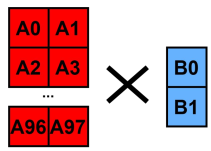
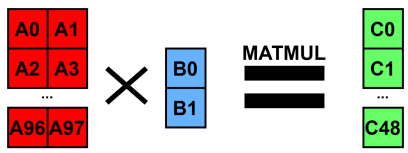

In [7]:
# ----------------------
# Splitting the matrices into 16 x 16 matrices and displaying the first block (for each matrix A & B) that would be obtained using `matrix_split.py`

# Block Input Matrices (Ai) (16 x 16)
block_input_matrix, input_block_col = matrix_split.matrix_splitting(input_matrix_padded, block_size, isWeight=False, isSquare=True)

# Block Weight Matrices (Bi) (16 x 16)
block_weight_matrix, weight_block_col = matrix_split.matrix_splitting(weight_matrix_padded, block_size, isWeight=True, isSquare=True)

print("A0 (",block_input_matrix[0].shape[0], "x", block_input_matrix[0].shape[1],") :\n\n", block_input_matrix[0], "\n")
print("B0 (",block_weight_matrix[0].shape[0], "x", block_weight_matrix[0].shape[1],") :\n\n", block_weight_matrix[0])

A0 ( 16 x 16 ) :

 [[-4 -1 -3 -1 -3  0 -2  0 -4  0 -3  0 -4  1 -2 -1]
 [ 0 -3  1 -2  0 -1 -4  2 -1 -1 -4 -2  0 -4 -4 -4]
 [-3 -3  1  0 -1  2 -2  0 -3  1 -4  1  0 -4 -3  1]
 [ 2 -2  1  0  1  1  2  0  1  1  1  0 -3  0 -3 -4]
 [-3 -4 -1  0 -2  0  0 -1 -2 -1 -3  0  1  1 -2  2]
 [-4  2  0  2 -1 -1 -3 -4 -1 -4 -2 -2  2 -1  1 -3]
 [ 0 -1 -1 -3 -2 -1 -2 -1  2 -1 -1 -1 -3  0  1  2]
 [-2  1 -4 -4 -2  0 -2 -4  0  1  2 -2 -1  0 -3  1]
 [-1  1 -2  2 -1  2  0  1 -4  2 -3 -2 -1  2 -3 -1]
 [-1 -2  0  2 -3  2  2 -4  1 -2  0 -4 -3 -4 -3 -1]
 [ 0 -2 -3 -4 -3  2 -1  0 -4 -1  0  1  1 -4  1 -3]
 [-4 -2 -3 -2 -2 -4  0 -2 -1 -1  1  2  2 -2 -1  2]
 [-2 -2  0 -3 -4 -1 -4 -4 -3  1  2 -4  2  1 -2  0]
 [-3 -4 -4 -2  1 -2  1 -1 -2  2 -4  1 -4 -1 -3 -4]
 [-4 -1 -3  2  0 -2 -2 -2  2  2 -2  0  1 -1 -4 -1]
 [-3  2 -1  1 -2 -2  2  0 -3  0  1 -2 -2 -4 -3  2]] 

B0 ( 16 x 16 ) :

 [[-2  2 -3 -2  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 2 -4 -4 -3  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 0 -4  1  2 -3  2  0  0  0  0  0  0  0 

The data of the input and weight matrices is encoded into the binary files `input.bin` and `weight.bin`. 
Each row of the input blocks are the input vectors (16 Bytes), and the (16x16) blocks of weight (256 Bytes) are the weight vectors used by the VTA.

The program `matrix_multiplication.py` can be used to predict the output matrix ACC (after GeMM), and to compare the expected output, and the actual results using the simulators.

It can also be used to retrieve the input data (Input vectors and Weight matrices) encoded in binary, which are generated in */compiler_output*. These can then be used in the simulators.


*Using the example of LeNet-5 first convolutional layer C1 :*

If `doWriteBinaryFile=True` in `user_configuration.py`, running this command will generate the binary files containing the data for the A block matrices, transposed B block matrices (input data) and expected output (ACC).
The following files will be generated in compiler_output/ : 
- `input.bin` : data for A
- `weight.bin` : data for B
- `expected_out_sram.bin` : expected output for cycle-accurate simulation
- `out_init.bin` : empty file to be overwritten by the simulation output
- `accumulator.bin` : empty file where the data is accumulated during the simulation process
- `memory_addresses.csv` : base physical addresses for each data type (INP, WGT, OUT, UOP, ACC)

    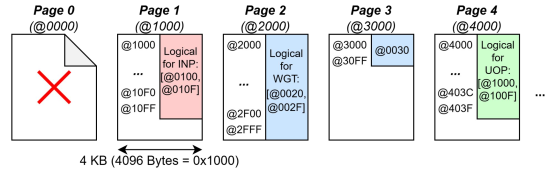

The base addresses are calculated according to vector size and bit-length. For the given example, here's how the data is stored in the DRAM:

To generate the binary files in /compiler_output folder, run the command :

In [8]:
%%capture
%run ../src/compiler/vta_compiler/data_definition/main_matrix_generator.py examples.data_lenet5_conv1